Exhaustive Grid Search Result
The best estimator's parameter is {'C': 1, 'eta': 0.05, 'lamda': 0.1, 'threshold': 0.4}
    rank_test_score  mean_test_score  mean_train_score  mean_fit_time  \
0                 1         0.865801          0.864719       0.048588   
1                 2         0.863636          0.876623       0.050715   
2                 3         0.859307          0.859307       0.051584   
3                 3         0.859307          0.859307       0.059569   
4                 3         0.859307          0.859307       0.045134   
5                 6         0.857143          0.874459       0.035575   
6                 6         0.857143          0.863636       0.035794   
7                 6         0.857143          0.863636       0.037949   
8                 9         0.854978          0.867965       0.038896   
9                10         0.852814          0.870130       0.077064   
10               10         0.852814          0.879870       0.036145   
11    

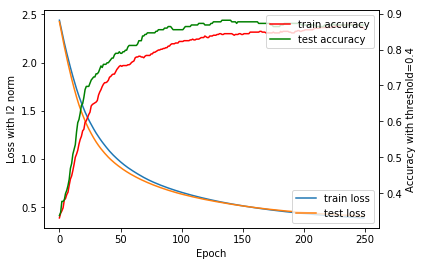

Figure of {'C': 1, 'eta': 0.1, 'lamda': 0.5, 'threshold': 0.4}


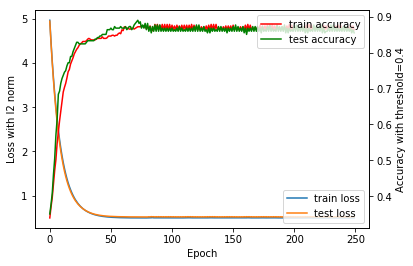

Figure of {'C': 1, 'eta': 0.1, 'lamda': 0.1, 'threshold': 0.6}


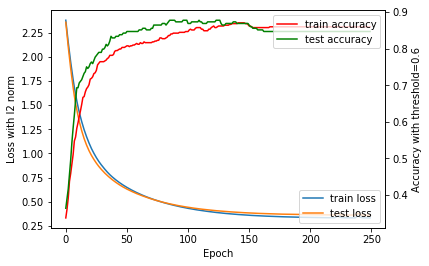

Figure of {'C': 1, 'eta': 0.1, 'lamda': 0.1, 'threshold': 0.5}


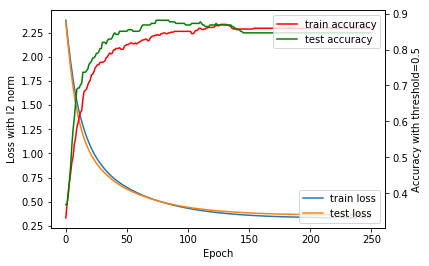

Figure of {'C': 1, 'eta': 0.1, 'lamda': 0.1, 'threshold': 0.4}


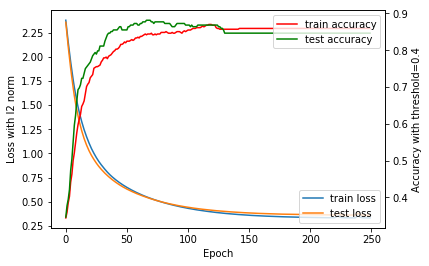

In [1]:
# -*- coding: utf-8 -*-

import numpy as np 
import scipy  
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.base import BaseEstimator,ClassifierMixin

class LinearClassifier(BaseEstimator,ClassifierMixin):  
    """A Linear Classifier for ML2017-lab-01"""
    
    def __init__(self, w=0, lamda=0, eta=0.1, C=1.0, threshold=0.5, max_epoch=50):
        """
        Called when initializing the classifier
        """
        self.w = w
        self.lamda = lamda
        self.eta = eta
        self.C = C
        self.threshold = threshold
        self.max_epoch = max_epoch
        
        self.w_history = []
        
    def __h(self,w,X):
        return X.dot(w)
    
    def h(self,X):
        return self.__h(self.w,X)
    
    def __hinge_loss(self,w,X,Y):
        num_records,num_features  = np.shape(X)  
        C = self.C
        zero = np.zeros((num_records,1))
        margin = 1 - C * Y * self.__h(w,X)
        return np.max([zero,margin],axis=0)    
    
    def hinge_loss(self,X,Y):
        return self.__hinge_loss(self.w,X,Y)
    
    def L(self,X,Y):
        return self.__L(self.w,X,Y)
    
    def __L(self,w,X,Y):
        num_records,num_features  = np.shape(X)  
        lamda = self.lamda
        e = self.__hinge_loss(w,X,Y)
        regulation_loss = 1.0/2 * lamda * w.transpose().dot(w)
        loss = 1.0/float(num_records) * e.sum()  + regulation_loss
        return loss[0][0]
        
    def g(self,X,Y):
        return self.__g(self.w,X,Y)
    
    def __g(self,w,X,Y):
        num_records,num_features  = np.shape(X)  
        C = self.C
        lamda = self.lamda
        e = self.__hinge_loss(w,X,Y)
        indicator = np.zeros((num_records,1))
        indicator[np.nonzero(e)] = 1
        
        return - 1.0/float(num_records) * C \
            * X.transpose().dot(Y * indicator).sum(axis=1).reshape((num_features,1)) \
            + lamda * w  
    
    
    def fit(self, X, Y):
        """
        A reference implementation of a fitting function
        Parameters
        ----------
        X : array-like or sparse matrix of shape = [n_samples, n_features]
            The training input samples.
        y : array-like, shape = [n_samples] or [n_samples, n_outputs]
            The target values (class labels in classification, real numbers in
            regression).
        Returns
        -------
        self : object
            Returns self.
        """
        self.classes_, _ = np.unique(Y, return_inverse=True)
        for epoch in range(self.max_epoch):
            self.w = self.w - self.eta * self.g(X,Y)
            self.w_history.append(self.w)
        
        return self    
    
    def __predict(self,w,X):
        threshold = self.threshold
        raw = self.__h(w,X)
        raw[raw<=threshold] = self.classes_[0]
        raw[raw>threshold] = self.classes_[1]
        return raw
    
    def predict(self, X):
        """ A reference implementation of a predicting function.
        Parameters
        ----------
        X : array-like of shape = [n_samples, n_features]
            The input samples.
        Returns
        -------
        y : array of shape = [n_samples]
            Returns :math:`x^2` where :math:`x` is the first column of `X`.
        """
        return self.__predict(self.w,X)
    
    def __score(self,w,X,Y):
        num_records,num_features  = np.shape(X)
        P = self.__predict(w,X)
        
        is_right = P * Y
        is_right[is_right < 0] = 0
        
        return 1.0/num_records * np.count_nonzero(is_right)
    
    def score(self, X, Y):
        # RMSE
        return self.__score(self.w,X,Y)
    
    def getLossHistory(self,X,Y):
        return [self.__L(w,X,Y) for w in self.w_history]
    
    def getScoreHistory(self,X,Y):
        return [self.__score(w,X,Y) for w in self.w_history]
    
    

data = load_svmlight_file("./resources/australian_scale.txt")
result_path = './results/classification_grid_search.csv'
# add interception
X = scipy.sparse.hstack(\
    (scipy.sparse.csr_matrix(np.ones((len(data[1]),1))),data[0]))
Y = data[1].reshape((len(data[1]),1))

num_records,num_features  = np.shape(X) 

X_train, X_test, Y_train, Y_test = train_test_split(\
X, Y, test_size=0.33,random_state=42)
Y_train = Y_train.reshape((len(Y_train),1))
Y_test = Y_test.reshape((len(Y_test),1))

# initialize w
init_w = np.random.normal(size=(num_features,1))

max_iterate = 250

param_grid = [
  {'lamda': [0, 0.1, 0.5], 
   'eta': [0.01, 0.02, 0.05, 0.1],
   'C': [1, 2],
   'threshold': [0.4,0.5,0.6]}
 ]


cls = GridSearchCV(LinearClassifier(init_w,max_epoch=max_iterate), param_grid,return_train_score=True)
cls.fit(X_train,Y_train)
result = pd.DataFrame(cls.cv_results_)
result.sort_values('rank_test_score',inplace=True)
result = result.reset_index(drop = True)

print ("Exhaustive Grid Search Result")
print ("The best estimator's parameter is",cls.best_params_)
print (result.loc[:,['rank_test_score','mean_test_score','mean_train_score','mean_fit_time','params']])
result.to_csv(result_path)
print ("Result has been saved in",result_path)

print ("Printing the best 5 models loss curves")
for i in range(5):
    params = result.loc[i,'params']
    print ("Figure of",params)
    classifier = LinearClassifier(init_w,max_epoch=max_iterate,**params)
    classifier.fit(X_train,Y_train)
    loss_train = classifier.getLossHistory(X_train,Y_train)
    loss_test = classifier.getLossHistory(X_test,Y_test)
    accuracy_train = classifier.getScoreHistory(X_train,Y_train)
    accuracy_test = classifier.getScoreHistory(X_test,Y_test)
    
    plt.figure(i)
    fig, ax = plt.subplots()
    ax_e = ax.twinx()
    train_loss_line = ax.plot(range(max_iterate),loss_train,label='train loss')
    test_loss_line = ax.plot(range(max_iterate),loss_test,label='test loss')
    train_accuracy_line = ax_e.plot(range(max_iterate),accuracy_train,'r',label='train accuracy')
    test_accuracy_line = ax_e.plot(range(max_iterate),accuracy_test,'g',label='test accuracy')
    
    ax.set(xlabel='Epoch', ylabel='Loss with l2 norm')
    ax_e.set_ylabel('Accuracy with threshold='+str(params['threshold']))
    
    ax.legend(loc=4)
    ax_e.legend(loc=1)
    plt.show()



